In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.models import NLinearModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import MetricCollection, MeanAbsoluteError, MeanSquaredError
import torch

torch.set_float32_matmul_precision('high')

In [2]:
base_path = 'stock_csv/'

column_mapping = {
    '일자': 'date',
    '종가': 'closing_price',
    '대비': 'price_difference',
    '등락률': 'fluctuation_rate',
    '시가': 'opening_price',
    '고가': 'highest_price',
    '저가': 'lowest_price',
    '거래량': 'trading_volume',
    '거래대금': 'trading_value',
    '시가총액': 'market_capitalization',
    '상장주식수': 'listed_shares',
}

In [3]:
stock_df = pd.read_excel(os.path.join(base_path, '005930_삼성전자_20000101_20230331.csv')).rename(columns=column_mapping)

stock_df.head()

/home/khg/miniconda3/envs/stock/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,closing_price,price_difference,fluctuation_rate,opening_price,highest_price,lowest_price,trading_volume,trading_value,market_capitalization,listed_shares
0,2023/03/31,64000,800,1.27,64000,64000,63700,14094479,900711556583,382066083200000,5969782550
1,2023/03/30,63200,500,0.80,63700,63700,63100,15684377,993903387442,377290257160000,5969782550
2,2023/03/29,62700,-200,-0.32,62500,62700,62200,11216008,700455977590,374305365885000,5969782550
3,2023/03/28,62900,800,1.29,62400,62900,62100,11614118,726295104112,375499322395000,5969782550
4,2023/03/27,62100,-900,-1.43,62600,62800,62000,11039331,687170094400,370723496355000,5969782550


과거 공변량:
<ol>
    <li>과거 주가 데이터: 종가, 시가, 고가, 저가 등
    <li>거래량: 주식 거래량 데이터
    <li>기술적 지표: 이동 평균, RSI (상대 강도 지수), MACD (이동 평균 수렴 발산) 등
    <li>기업 재무 데이터: 매출, 이익, 자산, 부채 등
    <li>배당: 배당금과 배당 수익률
    <li>주가 수익률 (P/E) 등의 가치 지표
</ol>
<br>
미래 공변량:
<ol>
    <li>경제 성장률: 국내 총생산(GDP) 성장률 등
    <li>인플레이션: 소비자 물가지수(CPI) 등
    <li>기준 금리: 중앙은행의 기준 금리
    <li>실업률: 국가의 실업률 데이터
    <li>환율: 외환 시장의 환율 정보
    <li>경제 정책: 정부의 경제 정책이나 중앙은행의 통화 정책
</ol>

In [4]:
past_cov_list = ['price_difference', 'fluctuation_rate', 'opening_price', 'highest_price', 'lowest_price', 'trading_volume',
                'trading_value', 'market_capitalization', 'listed_shares']
# past_cov_list = []

def getScaledPastCov(timeseries):
    past_cov_timeseries = timeseries.copy()
    cov_year = datetime_attribute_timeseries(past_cov_timeseries, attribute='year')
    cov_month = datetime_attribute_timeseries(past_cov_timeseries, attribute='month')
    past_cov = cov_year.stack(cov_month)
    for col in past_cov_list:
        past_cov = past_cov.stack(past_cov_timeseries[col])
    return Scaler().fit_transform(past_cov)

def getFutureCov(timeseries):
    pass

In [5]:
def write_pickle(file_path, data):
    with open(file_path, "wb") as f:
        pickle.dump(df, f)

def read_pickle(file_path):
    with open(file_path, "rb") as f:
        result = pickle.load(f)
    return result

In [17]:
logger = TensorBoardLogger('logs', name='stock')

# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MetricCollection([MeanAbsoluteError(), MeanSquaredError()])

# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsoluteError",  # "val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper], "logger": logger}

model = NLinearModel(input_chunk_length=20, output_chunk_length=5, n_epochs=10, random_state=42,
                     batch_size=8,
                        torch_metrics=torch_metrics,
                        pl_trainer_kwargs=pl_trainer_kwargs)

In [19]:
"""
    아래 코드의 속도 개선 중
"""
import time
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
start_time = time.time()


start_date = '2015-01-01'
end_date = '2023-03-31'

interpolate_list = ['closing_price'] + past_cov_list

list_stock_timeseries = []

list_train_series_scaled = []
list_val_series_scaled = []
list_scaler = []

list_scaled_past_cov = []
list_train_scaled_past_cov = []
list_val_scaled_past_cov = []

list_scaled_future_cov = []
list_train_scaled_future_cov = []
list_val_scaled_future_cov = []

c = 0
copy_list_train_series_scaled = []
copy_list_train_scaled_past_cov = []
copy_list_val_series_scaled = []
copy_list_val_scaled_past_cov = []

for i, file_name in enumerate(os.listdir(base_path)):
    df = pd.read_excel(base_path + file_name).rename(columns=column_mapping)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    if len(df.loc[:start_date]) == 0: # start_date 이전 날짜 데이터가 없는 경우는 무시. 따라서 start_date 이후 상장된 주식은 훈련 X
        continue
    df = df.loc[start_date:end_date]
    # 9.68초
    
    print(i, file_name)
    
    # Date interpolate
    stock_timeseries_df_interpolated = df.copy()
    stock_timeseries_df_interpolated = stock_timeseries_df_interpolated.asfreq('B')
    for col in interpolate_list:
        stock_timeseries_df_interpolated[col] = stock_timeseries_df_interpolated[col].interpolate(method='linear')
    df = stock_timeseries_df_interpolated
    # 25.73초
    
    timeseries = TimeSeries.from_dataframe(df)
    # 40.93초
    
    
    # Darts TimeSeries 변환 및 날짜 필터링
    stock_timeseries = timeseries['closing_price']
    list_stock_timeseries.append(stock_timeseries)

    # Past covariant 및 날짜 필터링
    scaled_past_cov_timeseries = getScaledPastCov(timeseries)
    list_scaled_past_cov.append(scaled_past_cov_timeseries)
    # 159.89초
    
    # Split train/validation set
    train_percentage = 0.8
    split_index = int(train_percentage * len(stock_timeseries))
    
    train_series, val_series = stock_timeseries[:split_index], stock_timeseries[split_index:]
    train_past_cov_series, val_past_cov_series = scaled_past_cov_timeseries[:split_index], scaled_past_cov_timeseries[split_index:]
    
    list_train_scaled_past_cov.append(train_past_cov_series)
    list_val_scaled_past_cov.append(val_past_cov_series)
    
    # Scale
    scaler = Scaler()
    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    list_scaler.append(scaler)
    
    list_train_series_scaled.append(train_series_scaled)
    list_val_series_scaled.append(val_series_scaled)
    # 899.29초
    
    copy_list_train_series_scaled.append(train_series_scaled)
    copy_list_val_series_scaled.append(val_series_scaled)
    copy_list_train_scaled_past_cov.append(train_past_cov_series)
    copy_list_val_scaled_past_cov.append(val_past_cov_series)
    
    c += 1
    if c % 100 == 0:
        model.fit(copy_list_train_series_scaled,
                past_covariates=copy_list_train_scaled_past_cov,
                # future_covariates=list_train_scaled_future_cov
                val_series=copy_list_val_series_scaled,
                val_past_covariates=copy_list_val_scaled_past_cov,
                # val_future_covariates=list_val_scaled_future_cov
                )
        
        copy_list_train_series_scaled = []
        copy_list_train_scaled_past_cov = []
        copy_list_val_series_scaled = []
        copy_list_val_scaled_past_cov = []

print(time.time() - start_time)
# Reset warning filter
warnings.filterwarnings('default')

1 086670_비엠티_20000101_20230331.csv
3 036200_유니셈_20000101_20230331.csv
5 053300_한국정보인증_20000101_20230331.csv
6 049830_승일_20000101_20230331.csv
7 006890_태경케미컬_20000101_20230331.csv
8 065710_서호전기_20000101_20230331.csv
9 013520_화승코퍼레이션_20000101_20230331.csv
10 054800_아이디스홀딩스_20000101_20230331.csv
11 199800_툴젠_20000101_20230331.csv
12 083790_크리스탈지노믹스_20000101_20230331.csv
13 005390_신성통상_20000101_20230331.csv
14 013310_아진산업_20000101_20230331.csv
15 005180_빙그레_20000101_20230331.csv
16 007700_F&F홀딩스_20000101_20230331.csv
18 004080_신흥_20000101_20230331.csv
21 035290_골드앤에스_20000101_20230331.csv
26 204620_글로벌텍스프리_20000101_20230331.csv
28 160550_NEW_20000101_20230331.csv
29 102260_동성케미컬_20000101_20230331.csv
30 192440_슈피겐코리아_20000101_20230331.csv
31 033200_모아텍_20000101_20230331.csv
32 004365_세방우_20000101_20230331.csv
34 086040_바이오톡스텍_20000101_20230331.csv
36 025870_신라에스지_20000101_20230331.csv
37 005965_동부건설우_20000101_20230331.csv
39 058420_제이웨이_20000101_20230331.csv
40 173940_에프엔씨엔터_20000101_20230

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

141 065350_신성델타테크_20000101_20230331.csv
142 005950_이수화학_20000101_20230331.csv
143 016590_신대양제지_20000101_20230331.csv
144 046310_백금T&A_20000101_20230331.csv
145 119610_인터로조_20000101_20230331.csv
146 011040_경동제약_20000101_20230331.csv
147 001130_대한제분_20000101_20230331.csv
148 094800_맵스리얼티1_20000101_20230331.csv
149 014570_고려제약_20000101_20230331.csv
150 030190_NICE평가정보_20000101_20230331.csv
152 002700_신일전자_20000101_20230331.csv
156 067170_오텍_20000101_20230331.csv
159 031440_신세계푸드_20000101_20230331.csv
160 119650_KC코트렐_20000101_20230331.csv
161 095700_제넥신_20000101_20230331.csv
163 004890_동일산업_20000101_20230331.csv
164 122870_와이지엔터테인먼트_20000101_20230331.csv
165 024060_흥구석유_20000101_20230331.csv
167 009470_삼화전기_20000101_20230331.csv
168 200470_에이팩트_20000101_20230331.csv
169 011080_형지I&C_20000101_20230331.csv
170 028080_휴맥스홀딩스_20000101_20230331.csv
172 074610_이엔플러스_20000101_20230331.csv
173 115160_휴맥스_20000101_20230331.csv
175 032500_케이엠더블유_20000101_20230331.csv
177 034120_SBS_20000101_2023033

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NLinearModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

298 192390_윈하이텍_20000101_20230331.csv
299 017510_세명전기_20000101_20230331.csv
300 088130_동아엘텍_20000101_20230331.csv
301 155900_바다로19호_20000101_20230331.csv
302 092460_한라IMS_20000101_20230331.csv
303 011785_금호석유우_20000101_20230331.csv
304 033830_티비씨_20000101_20230331.csv
305 085660_차바이오텍_20000101_20230331.csv
306 126600_BGF에코머티리얼즈_20000101_20230331.csv
307 189860_서전기전_20000101_20230331.csv
308 003075_코오롱글로벌우_20000101_20230331.csv
309 000240_한국앤컴퍼니_20000101_20230331.csv
310 041930_동아화성_20000101_20230331.csv
311 078940_코드네이처_20000101_20230331.csv
312 036620_감성코퍼레이션_20000101_20230331.csv
313 063440_SM Life Design_20000101_20230331.csv
314 032685_소프트센우_20000101_20230331.csv
315 064850_에프앤가이드_20000101_20230331.csv
316 078070_유비쿼스홀딩스_20000101_20230331.csv
319 095720_웅진씽크빅_20000101_20230331.csv
320 002790_아모레G_20000101_20230331.csv
321 037270_YG PLUS_20000101_20230331.csv
322 012700_리드코프_20000101_20230331.csv
323 006120_SK디스커버리_20000101_20230331.csv
324 047040_대우건설_20000101_20230331.csv
325 0766

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NLinearModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

447 018470_조일알미늄_20000101_20230331.csv
451 033560_블루콤_20000101_20230331.csv
452 002785_진흥기업우B_20000101_20230331.csv
453 082740_HSD엔진_20000101_20230331.csv
454 043610_지니뮤직_20000101_20230331.csv
455 039130_하나투어_20000101_20230331.csv
456 003030_세아제강지주_20000101_20230331.csv
457 106520_노블엠앤비_20000101_20230331.csv
460 073010_케이에스피_20000101_20230331.csv
461 086900_메디톡스_20000101_20230331.csv
463 203450_유니온커뮤니티_20000101_20230331.csv
465 000640_동아쏘시오홀딩스_20000101_20230331.csv
469 148250_알엔투테크놀로지_20000101_20230331.csv
472 066910_손오공_20000101_20230331.csv
474 014285_금강공업우_20000101_20230331.csv
475 056360_코위버_20000101_20230331.csv
476 089980_상아프론테크_20000101_20230331.csv
477 115570_스타플렉스_20000101_20230331.csv
483 001290_상상인증권_20000101_20230331.csv
484 086960_MDS테크_20000101_20230331.csv
485 003830_대한화섬_20000101_20230331.csv
486 019210_와이지-원_20000101_20230331.csv
487 114120_크루셜텍_20000101_20230331.csv
488 131400_이브이첨단소재_20000101_20230331.csv
489 109080_옵티시스_20000101_20230331.csv
490 042700_한미반도체_2000010

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NLinearModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

600 002320_한진_20000101_20230331.csv
601 107640_한중엔시에스_20000101_20230331.csv
603 003580_HLB글로벌_20000101_20230331.csv
604 019490_하이트론_20000101_20230331.csv
606 027710_팜스토리_20000101_20230331.csv
607 011320_유니크_20000101_20230331.csv
609 001790_대한제당_20000101_20230331.csv
612 108675_LX하우시스우_20000101_20230331.csv
616 051370_인터플렉스_20000101_20230331.csv
617 012620_원일특강_20000101_20230331.csv
618 037400_우리엔터프라이즈_20000101_20230331.csv
620 105740_디케이락_20000101_20230331.csv
621 001120_LX인터내셔널_20000101_20230331.csv
622 073540_에프알텍_20000101_20230331.csv
623 044380_주연테크_20000101_20230331.csv
624 093640_다믈멀티미디어_20000101_20230331.csv
628 091580_상신이디피_20000101_20230331.csv
629 200350_래몽래인_20000101_20230331.csv
631 005935_삼성전자우_20000101_20230331.csv
632 011280_태림포장_20000101_20230331.csv
633 138490_코오롱플라스틱_20000101_20230331.csv
634 066970_엘앤에프_20000101_20230331.csv
635 029460_케이씨_20000101_20230331.csv
638 057030_YBM넷_20000101_20230331.csv
641 073640_테라사이언스_20000101_20230331.csv
642 117580_대성에너지_20000101_202

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = NLinearModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

759 054050_농우바이오_20000101_20230331.csv
760 091590_남화토건_20000101_20230331.csv
761 010040_한국내화_20000101_20230331.csv
763 077970_STX엔진_20000101_20230331.csv
765 010280_쌍용정보통신_20000101_20230331.csv
767 001080_만호제강_20000101_20230331.csv
768 079430_현대리바트_20000101_20230331.csv


KeyboardInterrupt: 

In [9]:
# model.fit(list_train_series_scaled,
#             past_covariates=list_train_scaled_past_cov,
#             # future_covariates=list_train_scaled_future_cov
#             val_series=list_val_series_scaled,
#             val_past_covariates=list_val_scaled_past_cov,
#             # val_future_covariates=list_val_scaled_future_cov
#             )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 1.2 K 
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/khg/miniconda3/envs/stock/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/khg/miniconda3/envs/stock/lib/python3.10/site-packages/torch/utils/tensorboard/_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [7]:
# write_pickle('pickle/list_stock_timeseries', list_stock_timeseries)
# write_pickle('pickle/list_train_series_scaled', list_train_series_scaled)
# write_pickle('pickle/list_val_series_scaled', list_val_series_scaled)
# write_pickle('pickle/list_scaler', list_scaler)
# write_pickle('pickle/list_scaled_past_cov', list_scaled_past_cov)
# write_pickle('pickle/list_train_scaled_past_cov', list_train_scaled_past_cov)
# write_pickle('pickle/list_val_scaled_past_cov', list_val_scaled_past_cov)

In [8]:
# list_stock_timeseries = read_pickle('pickle/list_stock_timeseries')
# list_train_series_scaled = read_pickle('pickle/list_train_series_scaled')
# list_val_series_scaled = read_pickle('pickle/list_val_series_scaled')
# list_scaler = read_pickle('pickle/list_scaler')
# list_scaled_past_cov = read_pickle('pickle/list_scaled_past_cov')
# list_train_scaled_past_cov = read_pickle('pickle/list_train_scaled_past_cov')
# list_val_scaled_past_cov = read_pickle('pickle/list_val_scaled_past_cov')

In [10]:
model_path = "model/all_past2.pkl"
if not os.path.exists('model'):
    os.mkdir('model')
model.save(model_path)
model_loaded = NLinearModel.load(model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

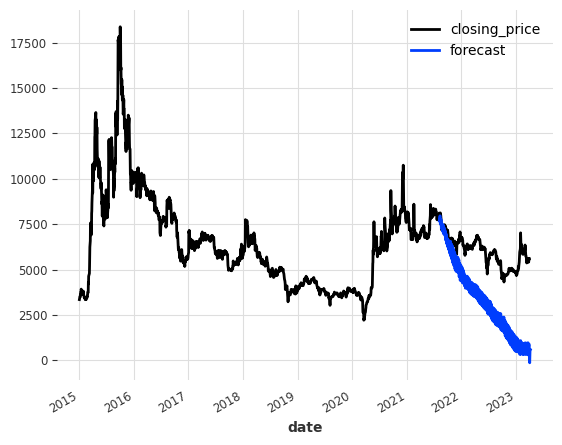

In [21]:
i = 2
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i])+5,
                                        series=list_train_series_scaled[i],
                                        past_covariates=list_scaled_past_cov[i],
                                        # future_covariates=list_scaled_future_cov[i],
                                        )
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i].plot()
prediction.plot(label="forecast")
plt.legend()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

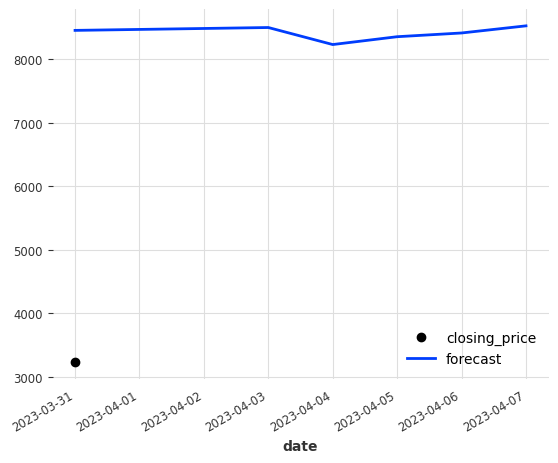

In [12]:
i = 11
predicted_series_scaled = model.predict(n=len(list_val_series_scaled[i])+5,
                                        series=list_train_series_scaled[i],
                                        past_covariates=list_scaled_past_cov[i],
                                        # future_covariates=list_scaled_future_cov[i],
                                        )
prediction = list_scaler[i].inverse_transform(predicted_series_scaled)
list_stock_timeseries[i][pd.to_datetime('2023-03-31'):].plot()
prediction[pd.to_datetime('2023-03-31'):].plot(label="forecast")
plt.legend()